# Pre-settings

#DATA Preprocessing

학습에 사용할 데이터를 data/mp4/train 폴더에 넣은 후 아래 코드 돌려서 얼굴 crop한 이미지와 wav 파일 얻기


In [1]:
# check video duration and frame rate
import cv2
import os

videolist = os.listdir("obama_video_25")
videolist.sort()
for video in videolist:
    cap = cv2.VideoCapture(os.path.join("obama_video_25", video))
    fps1 = cap.get(cv2.CAP_PROP_FPS)
    total_frame1 = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap = cv2.VideoCapture(os.path.join("obama_video_clip", video))
    fps2 = cap.get(cv2.CAP_PROP_FPS)
    total_frame2 = cap.get(cv2.CAP_PROP_FRAME_COUNT)

FileNotFoundError: [Errno 2] No such file or directory: 'obama_video_25'

In [ ]:
# clip video length
import os
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

videolist = os.listdir("obama_video_25")
videolist.sort()

origin_dir = "obama_video_25"
clip_dir = "obama_video_clip"

for video in videolist:
#     print(video)
    cap = cv2.VideoCapture(os.path.join(origin_dir, video))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = total_frame / fps
#     print(fps)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
#change video frame rate from 30 to 25
import os
import subprocess
from tqdm import tqdm

file_list = os.listdir("obama_video_clip")
file_list.sort()
for file in tqdm(file_list):
    command = 'ffmpeg -i {} -filter:v fps=25 {}'.format(os.path.join("obama_video_clip", file), os.path.join("obama_video_25", file))
    subprocess.call(command, shell=True)

  0%|          | 1/304 [00:28<2:23:05, 28.34s/it]


KeyboardInterrupt: 

In [ ]:
#extract video frames
# warning! the number of extracted frames should be dividable by 5.
import os
import subprocess
from tqdm import tqdm
import shutil

file_list = os.listdir("obama_video_25")
file_list.sort()
# for file in tqdm(file_list):
file = "obama296.mp4"
vidname = file.split('.')[0]
video_path = os.path.join("preprocessed_data", "video", vidname)
full_frame_path = os.path.join(video_path, "full")
crop_frame_path = os.path.join(video_path, "crop")
audio_path = os.path.join(video_path, "audio")

os.makedirs(audio_path, exist_ok=True)
os.makedirs(full_frame_path, exist_ok=True)
os.makedirs(crop_frame_path, exist_ok=True)

# create full frame images : too large size
command = 'ffmpeg -hide_banner -y -i {} -r 25 {}'.format(os.path.join("obama_video_25", file), os.path.join(full_frame_path, '%05d.png'))
subprocess.call(command, shell=True)

# create audio file
command = 'ffmpeg -hide_banner -y -i {} {}'.format(os.path.join("obama_video_25", file), os.path.join(audio_path, 'audio.aac'))
subprocess.call(command, shell=True)

# create cropped frame
command = 'python utils/crop_portrait.py --data_dir {} --crop_level 1.3 --vertical_adjust 0.2'.format(video_path)
subprocess.call(command, shell=True)

#remove full frame images
shutil.rmtree(full_frame_path)
command = 'rm -rf ~/.local/share/Trash/files/*'
subprocess.call(command, shell=True)

0

In [10]:
from IPython.display import Video

#origin
# Video("obama_video_25/obama1.mp4")

# source audio
# Video("obama_video_25/obama10.mp4")

# #reenact
# Video("preprocessed_data/video/obama10/result.mp4")

# #debug
Video("data/kkj/kkj00/debug.mp4", embed=True)

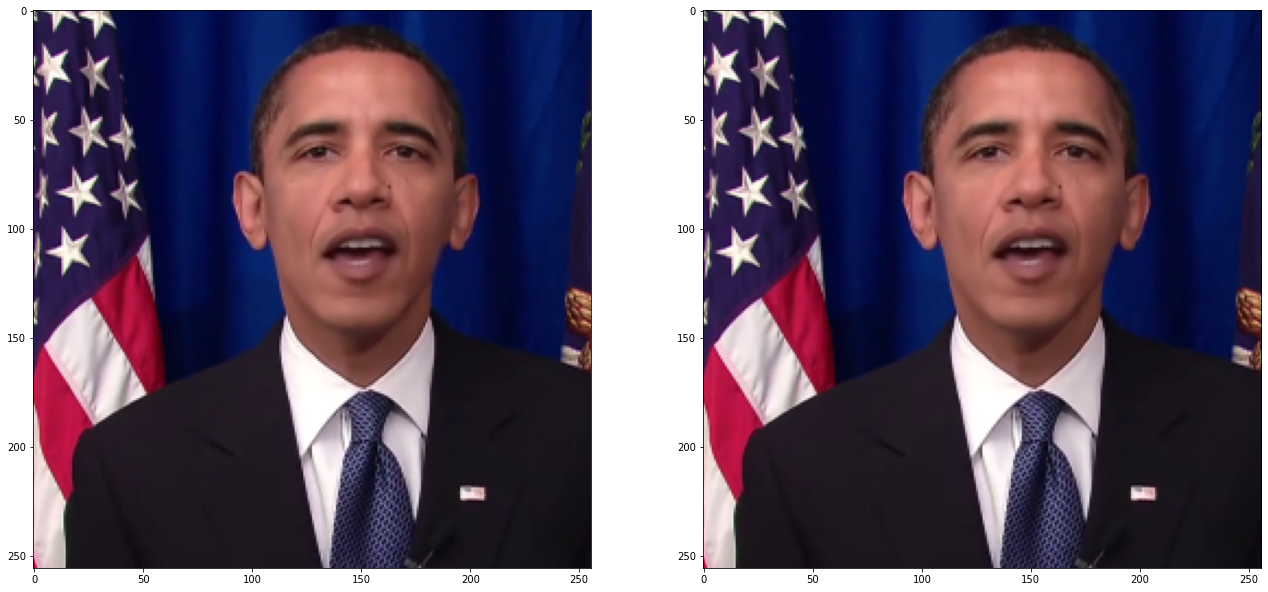

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils.util import create_dir, get_file_list


if __name__ == '__main__':
    src_dir = "preprocessed_data/video/obama10"
    tgt_dir = "preprocessed_data/video/obama296"

    foregrounds = get_file_list(os.path.join(src_dir, 'images'), suffix='fake')
    backgrounds = get_file_list(os.path.join(tgt_dir, 'crop'))
    masks = get_file_list(os.path.join(tgt_dir, 'mask'))

    i= 200
    fg = cv2.imread(foregrounds[i])
    bg = cv2.imread(backgrounds[i])
    
    
    mask_fg = cv2.cvtColor(fg.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    mask_fg = ((mask_fg > 0) * 255).astype(np.uint8)
    mask_fg = cv2.erode(mask_fg, np.ones((3,3), np.uint8), iterations=3)
    mask_fg = cv2.cvtColor(mask_fg, cv2.COLOR_GRAY2BGR)
    mask_fg = cv2.GaussianBlur(mask_fg, (5,5), cv2.BORDER_DEFAULT) / 255.0
    
    cover_img = mask_fg * fg + (1 - mask_fg) * bg

    mask = cv2.imread(masks[i])
    mask = cv2.erode(mask, np.ones((3,3), np.uint8), iterations=3)
    mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_DEFAULT) / 255.0

    comp = mask * cover_img + (1 - mask) * bg
    result_fg = cover_img
    result_bg = comp
    result_fg = cv2.cvtColor(result_fg.astype(np.uint8), cv2.COLOR_BGR2RGB)
    result_bg = cv2.cvtColor(result_bg.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(22, 11))   # 직접 Figure 객체를 생성
    ax_fg = plt.subplot(1, 2, 1)   # 직접 axes를 생성
    ax_fg.imshow(result_fg)
    ax_bg = plt.subplot(1, 2, 2)
    ax_bg.imshow(result_bg)
    plt.show()

In [61]:
import scipy.io as sio
import torch
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
from tqdm import tqdm

class transformation():
    def __init__(self, opt, src_alpha, tgt_alpha):
        self.opt = opt
        self.mat_data = sio.loadmat(opt.matlab_data_path)
        self.geo_mean = self.mat_data['geo_mean'].astype(np.float64)
        self.id_base = self.mat_data['id_base'].astype(np.float64)
        self.exp_base = self.mat_data['exp_base'].astype(np.float64)
        self.triangles64 = self.mat_data['triangles']
        self.src_alpha = src_alpha.clone().detach().numpy().astype(np.float64)
        self.tgt_alpha = tgt_alpha.clone().detach().numpy().astype(np.float64)
        
        self.src_geometry = (self.geo_mean + self.id_base @ self.src_alpha).reshape(-1, 3)
        self.tgt_geometry = (self.geo_mean + self.id_base @ self.tgt_alpha).reshape(-1, 3)
    
        self.src_span = self.get_span(self.src_geometry)
        self.tgt_span = self.get_span(self.tgt_geometry)

        self.src_inv_span = np.linalg.inv(self.src_span)
        self.tgt_inv_span = np.linalg.inv(self.tgt_span)
        
        self.V_hat = self.get_transform_matrix()
        self.A = self.get_A()
        self.LU = sparse.linalg.splu((self.A.T @ self.A).tocsc())
    
    
    def span_components(self, geometry):
        triangles64 = self.triangles64

        v1 = geometry[triangles64[:, 0], :]
        v2 = geometry[triangles64[:, 1], :]
        v3 = geometry[triangles64[:, 2], :]

        a = v2 - v1
        b = v3 - v1
        tmp = np.cross(a, b)
        c = (tmp.T / np.sqrt(np.linalg.norm(tmp, axis=1))).T
        
        return a, b, c
    
    
    def v1(self):
        return self.tgt_geometry[self.triangles64[:, 0], :]
    
    
    def get_span(self, geometry):
        a, b, c = self.span_components(geometry)
        return np.transpose((a, b, c), (1, 2, 0))
    
    
    def get_transform_matrix(self):
        row = np.array([0, 1] * 3)
        data = np.array([-1, -1, 1, 0, 0, 1])
        vertices = self.tgt_geometry
        triangles = self.triangles64
        sparse_matrix = []
        
        for f in tqdm(triangles, total=len(triangles)):
            i0, i1, i2 = f
            col = np.array([i0, i0, i1, i1, i2, i2])
            sparse_matrix.append(sparse.coo_matrix((data, (row, col)), shape=(2, len(vertices)), dtype=np.float64))       
        return sparse.vstack(sparse_matrix, dtype=np.float64).tocsc()
    
    def get_A(self):
        V_hat = self.V_hat
        exp_base = self.exp_base.reshape(35709, 3*64)
        A = V_hat.dot(exp_base).reshape(-1, 64)
        return sparse.csr_matrix(A)
        
    
    def deformation_transfer(self, src_delta):
        src_pose = self.src_geometry + (self.exp_base @ src_delta.numpy().astype(np.float64)).reshape(-1, 3)
        self.src_pose = src_pose
        src_pose_span = self.get_span(src_pose)
        s = ((src_pose_span @ self.src_inv_span) @ self.tgt_span[:, :, :2]).transpose(0, 2, 1)
        b = (np.concatenate(s) - self.V_hat.dot(self.tgt_geometry)).reshape(-1, 1)
        x = self.LU.solve(self.A.T @ b)
        return torch.from_numpy(x)
    
    def to_fourth_dimension(self):
        a, b, c = self.span_components(self.tgt_geometry)
        v4 = self.v1() + c
        new_vertices = np.concatenate((self.tgt_geometry, v4), axis=0)
        v4_indices = np.arange(len(self.tgt_geometry), len(self.tgt_geometry) + c.shape[0])
        new_triangles = np.concatenate((self.triangles64, v4_indices.reshape(-1, 1)), axis=1)
        
        return new_vertices, new_triangles

In [1]:
import os
import cv2
from tqdm import tqdm
import torch
from torchvision import utils
import numpy as np
from renderer.face_model import FaceModel
from options.options import Options
from audiodvp_utils.util import create_dir, load_coef, get_file_list, get_max_crop_region
from audiodvp_utils.rescale_image import rescale_and_paste
import scipy.io as sio
from audiodvp_utils.deformation_transfer import transformation


opt = Options().test_parse_args()
opt.src_dir = "data/obama296_short"
opt.tgt_dir = "data/kkj04_5min"

create_dir(os.path.join(opt.src_dir, 'reenact_deformation'))
alpha_list = load_coef(os.path.join(opt.tgt_dir, 'alpha'))
beta_list = load_coef(os.path.join(opt.tgt_dir, 'beta'))
src_delta_list = load_coef(os.path.join(opt.src_dir, 'delta'))
src_alpha_list = load_coef(os.path.join(opt.src_dir, 'alpha'))
gamma_list = load_coef(os.path.join(opt.tgt_dir, 'gamma'))
angle_list = load_coef(os.path.join(opt.tgt_dir, 'rotation'))
translation_list = load_coef(os.path.join(opt.tgt_dir, 'translation'))
crop_region_list = load_coef(os.path.join(opt.tgt_dir, 'crop_region'))
full_image_list = get_file_list(os.path.join(opt.tgt_dir, 'full'))
masks = get_file_list(os.path.join(opt.tgt_dir, 'mask'))

opt.data_dir = opt.tgt_dir

opt.batch_size = 1

transfer = transformation(opt, src_alpha_list[0], alpha_list[0])

face_model = FaceModel(opt=opt, batch_size=1, load_model=True)

top, bottom, left, right = get_max_crop_region(crop_region_list)

for i in tqdm(range(len(src_delta_list))):
    alpha = alpha_list[0].unsqueeze(0).cuda()
    beta = beta_list[0].unsqueeze(0).cuda()
    delta = src_delta_list[i]
    new_delta = transfer.deformation_transfer(delta).unsqueeze(0).cuda()
    
    # idx = i % (opt.offset_end - opt.offset_start ) + opt.offset_start
    idx = i
    gamma = gamma_list[idx].unsqueeze(0).cuda()
    rotation = angle_list[idx].unsqueeze(0).cuda()
    translation = translation_list[idx].unsqueeze(0).cuda()
    crop_region = crop_region_list[idx]
    full = cv2.imread(full_image_list[idx])
    mask = cv2.imread(masks[idx]) / 255.0
    H, W, _ = full.shape
    empty_image = np.zeros((H, W, 3), np.uint8)
    render, _, _, _, _ = face_model(alpha, new_delta, beta, rotation, translation, gamma)
    render = render.squeeze().mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    
    rescaled_render = rescale_and_paste(crop_region, empty_image, render)
    rescaled_render = cv2.cvtColor(rescaled_render, cv2.COLOR_RGB2BGR)
    rescaled_render = rescaled_render[top:bottom, left:right]
    rescaled_render = cv2.resize(rescaled_render, (opt.image_width, opt.image_height), interpolation=cv2.INTER_AREA)
    
    rescaled_crop = full[top:bottom, left:right]
    rescaled_crop = cv2.resize(rescaled_crop, (opt.image_width, opt.image_height), interpolation=cv2.INTER_AREA)
    
    masked_crop = rescaled_crop * (1 - mask)
    masked_render = rescaled_render * mask
    masked_image = masked_crop + masked_render
    
    cv2.imwrite(os.path.join(opt.src_dir, 'reenact_deformation', '%05d.png' % (i+1)), masked_image)


100%|██████████| 1750/1750 [06:39<00:00,  4.38it/s]


In [6]:
import torch

A = torch.randn([204, 7500])

'torch.FloatTensor'

In [50]:
transfer = transformation(opt, src_alpha_list[0], alpha_list[0])
delta = src_delta_list[0]
x = transfer.deformation_transfer(delta)

100%|██████████| 70789/70789 [00:04<00:00, 17575.63it/s]


(424734, 1)
(64, 64)


In [58]:
tgt_pose = transfer.tgt_geometry + (transfer.exp_base @ x).reshape(-1, 3)
tgt_pose_no_defor = transfer.tgt_geometry + (transfer.exp_base @ delta.numpy().astype(np.float64)).reshape(-1, 3)

In [60]:
idx = 10
print(transfer.src_geometry[idx])
print(transfer.src_pose[idx])
print(transfer.tgt_geometry[idx])
print(tgt_pose[idx])
print(tgt_pose_no_defor[idx])

[-0.76667963  0.53011646  0.86886806]
[-0.76370103  0.53072804  0.87038392]
[-0.70637111  0.49959928  0.87430746]
[-0.70361401  0.50016358  0.87575429]
[-0.70339251  0.50021086  0.87582332]


In [15]:
x + np.array([0.15432841, 0.28833679, 0.99362701])

array([[-0.7580038 ,  0.95862652,  1.19826967],
       [-0.75753483,  0.95496326,  1.19892649],
       [-0.75697789,  0.95131575,  1.19953124],
       ...,
       [ 0.88476206, -0.18368204,  0.5776004 ],
       [ 0.88587198, -0.18121232,  0.56796131],
       [ 0.88629734, -0.17810075,  0.55842294]])

In [103]:

transfer.src_pose

array([[-0.76971294,  0.580409  ,  0.87038339],
       [-0.76924396,  0.57674574,  0.87104021],
       [-0.76868702,  0.57309823,  0.87164497],
       ...,
       [ 0.87305293, -0.56189956,  0.24971412],
       [ 0.87416284, -0.55942984,  0.24007503],
       [ 0.8745882 , -0.55631826,  0.23053666]])

In [26]:
V = np.random.rand(2, 35709)
A = V @ transfer.exp_base.reshape(35709, 3, 64).reshape(35709, -1)
A.shape

(2, 192)

In [94]:
src_pose_span = transfer.get_span(transfer.src_pose)
s = (src_pose_span @ transfer.src_inv_span).transpose(0, 2, 1)
s[0]

array([[ 1.00656431, -0.00524499, -0.00239141],
       [ 0.00955085,  1.01162632,  0.00600172],
       [-0.00116585,  0.0014922 ,  1.0048915 ]])

In [68]:
v1 = t1[0]
v2 = t1[1]
v3 = t1[2]
v4 = t1[3]

print(v2-v1)
print(v3-v1)
print(v4-v1)
print(v1.dtype)
np.dot(v3-v1, v4-v1)

[ 0.00108685 -0.00604855 -0.00122652]
[ 0.0049349  -0.00222809  0.00761819]
[-0.00642065 -0.00188529  0.00360777]
float64


-1.2874900798265365e-19

In [6]:
import torch
import librosa
from audiodvp_utils import util, audio

audio_path = "data/kkj/kkj04_short/audio/audio.wav"
wav = librosa.load(audio_path,16000)[0]
mel2 = audio.melspectrogram(wav)

In [7]:
torch_wav = torch.from_numpy(wav).unsqueeze(0)
torch_wav.min()

tensor(-0.5760)

In [1]:
from lipsync3d.utils import viterbi_algorithm, get_metadata
from audiodvp_utils import util
import os 

src_dir = "data/tcdtimit4"
tg_path = "data/tcdtimit_test/42_sx97.TextGrid"
metadata = get_metadata(src_dir)
delta_list = viterbi_algorithm(src_dir, tg_path)
# print(viterbi_idx)

preparing Viterbi
running Viterbi
viterbi done!
|silent silent 	| 24 26 	| None 	|3036
|P P 	| 2 2 	| 0.208 	|602
|EH EH 	| 1 1 	| 0.214 	|1141
|NG NG 	| 3 3 	| 0.332 	|414
|G G 	| 2 2 	| 0.129 	|2065
|W W 	| 1 1 	| 0.182 	|2700
|AH AH 	| 1 1 	| 0.082 	|2701
|N N 	| 2 2 	| 0.155 	|1934
|Z Z 	| 2 2 	| 0.122 	|305
|L L 	| 2 2 	| 0.161 	|1810
|IH IH 	| 1 1 	| 0.105 	|1387
|V V 	| 2 2 	| 0.127 	|1293
|N N 	| 1 1 	| 0.124 	|1144
|IH IH 	| 2 2 	| 0.255 	|1454
|R R 	| 2 2 	| 0.185 	|1938
|DH DH 	| 1 1 	| 0.223 	|1274
|IY IY 	| 3 3 	| 0.207 	|2983
|AY AY 	| 4 4 	| 0.166 	|1024
|S S 	| 4 4 	| 0.272 	|1223
|IY IY 	| 2 2 	| 0.284 	|1057
|AE AE 	| 1 1 	| 0.203 	|1021
|N N 	| 3 3 	| 0.140 	|2204
|T T 	| 2 2 	| 0.134 	|132
|AA AA 	| 1 1 	| 0.306 	|2228
|R R 	| 1 1 	| 0.215 	|1513
|K K 	| 3 3 	| 0.142 	|896
|T T 	| 1 1 	| 0.135 	|367
|IH IH 	| 1 1 	| 0.172 	|1387
|K K 	| 3 3 	| 0.179 	|1192
|silent silent 	| 27 26 	| 0.144 	|3036


100%|██████████| 11155/11155 [00:01<00:00, 7903.76it/s]


In [6]:
origin_delta_list = delta_list
interpolated_delta_list = []

prev_delta = None
prev_delta_idx = -1
for idx in range(len(delta_list)):
    if delta_list[i] == None:
        continue
    else:
        if prev_delta == None:
            for _ in range(prev_delta_idx, idx):
                interpolated_delta_list.append(delta_list[idx])

None
None
None
None
None
None
None
None
None
None
None
None
Tensor!
None
None
None
None
None
None
None
None
None
None
None
None
Tensor!
Tensor!
None
Tensor!
None
None
Tensor!
Tensor!
Tensor!
None
Tensor!
None
Tensor!
None
Tensor!
Tensor!
None
Tensor!
Tensor!
None
Tensor!
None
Tensor!
Tensor!
None
Tensor!
None
None
None
Tensor!
None
None
None
Tensor!
None
None
Tensor!
Tensor!
None
Tensor!
None
None
Tensor!
Tensor!
Tensor!
None
Tensor!
None
Tensor!
Tensor!
None
Tensor!
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Tensor!
None
None
None
None
None
None
None
None
None
None
None
None
None


In [4]:
from audiodvp_utils.util import get_file_list
import cv2
full_image_list = get_file_list(os.path.join(src_dir, 'full'))

frame_paths = []
for idx in viterbi_idx:
    frame_paths.append(full_image_list[idx])
    
frame = cv2.imread(frame_paths[0])
H, W, _ = frame.shape
fps = 25
out_vid_path = 'data/tcdtimit_test/outvid.mp4'
out = cv2.VideoWriter(out_vid_path, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (W, H))
for t in range(len(frame_paths)):
    frame = cv2.imread(frame_paths[t])
    out.write(frame)
out.release()
print("made video ", out_vid_path)

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


made video  data/tcdtimit_test/outvid.mp4


In [50]:
p_mean = pitch.mean()
p_std = pitch.std()
((pitch - p_mean) / p_std)

AttributeError: 'list' object has no attribute 'mean'

In [1]:
from lipsync3d.utils import get_audio_energy_pitch

energy, pitch, e_mean, e_std, p_mean, p_std = get_audio_energy_pitch("data/kkj/kkj04_short")

torch.Size([1, 60001])
torch.Size([1, 60001])
audio energy pitch pre-processing...


100%|██████████| 15000/15000 [00:03<00:00, 4732.29it/s]


In [1]:
import tgt
import librosa
import torch
from lipsync3d.utils import get_metadata

metadata = get_metadata("data/studio1")


560.2499999999999
metadata saved.


In [9]:
import torch
from lipsync3d.utils import landmarkdict_to_normalized_mesh_tensor
A = torch.load('data/kkj/kkj04_lipsync3d/mesh_dict/00004.pt')
idx = 10
print(A[idx])
landmarkdict_to_normalized_mesh_tensor(A)[idx]

[150.2241668701172, 48.349632263183594, 4.785555362701416]


tensor([151.8584,  52.8554,   7.0807])

In [3]:
import utils
from lib.mesh_io import read_obj
refer_mesh = read_obj(os.path.join('renderer', 'data', 'bfm09_face_template.obj'))
laplacians,downsamp_trans, upsamp_trans, pool_size = utils.init_sampling(
refer_mesh, os.path.join('renderer', 'data', 'params', 'bfm09_face'), 'bfm09_face')

In [1]:
import os
import cv2
import torch
import numpy as np
from renderer.face_model import FaceModel
from audiodvp_utils.util import load_coef
from lib.mesh_io import read_obj
from gcn_util.utils import init_sampling
import scipy.io as sio
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--src_dir', type=str, default="data/kkj/kkj_last")
parser.add_argument('--tgt_dir', type=str, default="data/kkj/kkj04")
parser.add_argument('--matlab_data_path', type=str, default='renderer/data/data.mat')
opt = parser.parse_args(args=[])
opt.data_dir = opt.tgt_dir

alpha = torch.load(os.path.join(opt.tgt_dir, 'reference_alpha.pt')).unsqueeze(0).cuda()
delta_list = load_coef(os.path.join(opt.tgt_dir, 'delta'))
angle_list = load_coef(os.path.join(opt.tgt_dir, 'rotation'))
translation_list = load_coef(os.path.join(opt.tgt_dir, 'translation'))

face_model = FaceModel(opt=opt, batch_size=1, load_model=True, downsamp_tran=None)

idx = 22
delta = delta_list[idx].unsqueeze(0).cuda()
rotation = angle_list[idx].unsqueeze(0).cuda()
translation = translation_list[idx].unsqueeze(0).cuda()

delta = delta_list[idx].unsqueeze(0).cuda()
landmarks = face_model.downsampled_landmarks(alpha, delta, rotation, translation)
empty_image = 255 * np.ones((256, 256, 3), np.uint8)
n = landmarks.shape[0]
for i in range(n):
    x, y = int(landmarks[i][0].item()), int(landmarks[i][1].item())
    empty_image = cv2.circle(empty_image, (x,y), radius=0, color=(0, 0, 0), thickness=-1)

cv2.imwrite('test_image_bfm_mesh.png', empty_image)




100%|██████████| 29060/29060 [00:03<00:00, 7893.17it/s]


True

In [32]:
for _, bfm_idx in media_to_bfm_dict.items():
    x, y = int(landmarks[bfm_idx][0]), int(landmarks[bfm_idx][1])
    empty_image = cv2.circle(empty_image, (x,y), radius=0, color=(0, 255, 0), thickness=-1)

cv2.imwrite('test_image_bfm_mesh_downsampled.png', empty_image)

True

In [13]:
import mediapipe.python.solutions.face_mesh as mp_face_mesh
import mediapipe.python.solutions.drawing_utils as mp_drawing
import mediapipe.python.solutions.drawing_styles as mp_drawing_styles
from audiodvp_utils import util
import cv2
from lipsync3d.utils import landmark_to_dict, landmarkdict_to_mesh_tensor
from lipsync3d.pose_normalization import normalized_to_pixel_coordinates

data_dir = "data/kkj/kkj04"
image_list = util.get_file_list(os.path.join(data_dir, 'crop'))
idx = 22
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:

    image = cv2.imread(image_list[idx])
    annotated_image = image.copy()
    image_rows, image_cols, _ = image.shape
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    target_dict = landmark_to_dict(results.multi_face_landmarks[0].landmark)
    target_dict = normalized_to_pixel_coordinates(target_dict, 256, 256)
    target_dict = landmarkdict_to_mesh_tensor(target_dict)


256
256


In [5]:
import torch

alpha = torch.load("data/kkj/kkj04_short/alpha/00004.pt")
torch.sum(alpha**2)

tensor(50.4567)

In [2]:
from imutils import face_utils
import numpy as np
import imutils
import cv2
import face_recognition
import tqdm
from audiodvp_utils import util, face_detection
data_dir = "./data/tcdtimit4"

fa = face_detection.FaceAlignment(face_detection.LandmarksType._2D, flip_input=False, device='cuda')

image_list = util.get_file_list(os.path.join(data_dir, 'full'))

batch_size = 5
frames = []

for i in tqdm(range(len(image_list))):
    frame = face_recognition.load_image_file(image_list[i])
    frames.append(frame)

H, W, _ = frames[0].shape

batches = [frames[i:i + batch_size] for i in range(0, len(frames), batch_size)]

for idx in tqdm(range(len(batches))):
    fb = batches[idx]
    preds = fa.get_detections_for_batch(np.asarray(fb))

ModuleNotFoundError: No module named 'face_detection'

In [2]:
import os
import cv2
from tqdm import tqdm
import torch
from torchvision import utils
import numpy as np
from renderer.face_model import FaceModel
# from options.options import Options
from audiodvp_utils.util import create_dir, load_coef, load_face_emb, get_file_list, get_max_crop_region
from audiodvp_utils.rescale_image import rescale_and_paste

if __name__ == '__main__':
    # opt = Options().parse_args()
    # opt.tgt_dir = "data/kkj/kkj03"
    # value = 5.0
    # create_dir(os.path.join(opt.tgt_dir, 'delta_test'))

    # alpha_list = load_coef(os.path.join(opt.tgt_dir, 'alpha'))
    # beta_list = load_coef(os.path.join(opt.tgt_dir, 'beta'))
    # gamma_list = load_coef(os.path.join(opt.tgt_dir, 'gamma'))
    # angle_list = load_coef(os.path.join(opt.tgt_dir, 'rotation'))
    # translation_list = load_coef(os.path.join(opt.tgt_dir, 'translation'))
    # crop_region_list = load_coef(os.path.join(opt.tgt_dir, 'crop_region'))
    # full_image_list = get_file_list(os.path.join(opt.tgt_dir, 'full'))

    alpha_list = load_coef(os.path.join("data/kkj/kkj04", 'alpha'))
    print(alpha_list[0].shape)
    # opt.data_dir = opt.tgt_dir

    # face_emb_list = load_face_emb(opt.data_dir)
    # face_model = FaceModel(opt=opt, batch_size=1, load_model=True)

    # top, bottom, left, right = get_max_crop_region(crop_region_list)

    # for delta_idx in tqdm(range(64)):
    #     for is_pos in [True, False]:
    #         idx=10
    #         delta = torch.zeros((1, 64, 1)).cuda()

    #         if is_pos:
    #             delta[0][delta_idx][0] = value
    #         else:
    #             delta[0][delta_idx][0] = -value

    #         alpha = alpha_list[idx].unsqueeze(0).cuda()
    #         beta = beta_list[idx].unsqueeze(0).cuda()
    #         gamma = gamma_list[idx].unsqueeze(0).cuda()
    #         rotation = angle_list[idx].unsqueeze(0).cuda()
    #         translation = translation_list[idx].unsqueeze(0).cuda()
    #         face_emb = face_emb_list[idx].unsqueeze(0).cuda()
    #         crop_region = crop_region_list[idx]
    #         full_image = cv2.imread(full_image_list[idx])
    #         H, W, _ = full_image.shape
    #         empty_image = np.zeros((H, W, 3), np.uint8)
    #         render, _, _, _, _ = face_model(alpha, delta, beta, rotation, translation, gamma, face_emb, lower=False)
    #         render = render.squeeze().mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
            
    #         rescaled_render = rescale_and_paste(crop_region, empty_image, render)
    #         rescaled_render = cv2.cvtColor(rescaled_render, cv2.COLOR_RGB2BGR)
    #         rescaled_render = rescaled_render[top:bottom, left:right]
    #         rescaled_render = cv2.resize(rescaled_render, (opt.image_width, opt.image_height), interpolation=cv2.INTER_AREA)
    #         cv2.imwrite(os.path.join(opt.tgt_dir, 'delta_test', 'delta_test_{}_{}.png'.format(delta_idx, str(is_pos))), rescaled_render)


usage: ipykernel_launcher.py [-h] [--data_dir DATA_DIR]
                             [--dataset_mode DATASET_MODE]
                             [--pretrained_model_path PRETRAINED_MODEL_PATH]
                             [--matlab_data_path MATLAB_DATA_PATH]
                             [--skin_mask_path SKIN_MASK_PATH]
                             [--face_id_path FACE_ID_PATH]
                             [--num_epoch NUM_EPOCH] [--epoch_tex EPOCH_TEX]
                             [--epoch_warm_up EPOCH_WARM_UP]
                             [--batch_size BATCH_SIZE] [--Nw NW]
                             [--serial_batches SERIAL_BATCHES]
                             [--num_workers NUM_WORKERS] [--isTrain ISTRAIN]
                             [--max_dataset_size MAX_DATASET_SIZE]
                             [--gpu_ids GPU_IDS] [--lr LR]
                             [--lambda_photo LAMBDA_PHOTO]
                             [--lambda_land LAMBDA_LAND]
                             [--la

SystemExit: 2

/home/server01/anaconda3/envs/jyeongho/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
import torch

dt = torch.stack(deltas, dim=0).squeeze()


[]

In [30]:
!./scripts/demo.sh

++ target_dir=data/kkj/kkj03
++ source_dir=data/obama296
++ video_dir=data/kkj/kkj03/KKJ_slow_03_stand.mp4
++ start_time=00:00:00
++ end_time=240
++ python audio_feature_extract.py --data_dir data/kkj/kkj03
Instructions for updating:
non-resource variables are not supported in the long term
Audio has multiple channels, only first channel is considered
2021-08-25 11:44:35.472100: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-08-25 11:44:35.498966: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2199985000 Hz
2021-08-25 11:44:35.502042: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561ba6461740 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-25 11:44:35.502093: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-25 11:44